In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

np.random.seed(17)
tf.random.set_seed(17)

In [2]:
discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        
        tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.GlobalMaxPooling2D(),
        
        tf.keras.layers.Dense(1),
    ],
    name="discriminator", )
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 128)       0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [3]:
# Generator
latent_dim = 128

generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        
        tf.keras.layers.Dense(14 * 14 * 128),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Reshape((14, 14, 128)),
        
        tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        
        tf.keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 25088)             3236352   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       73792     
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 64)       0         
 )                                                       

In [4]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255

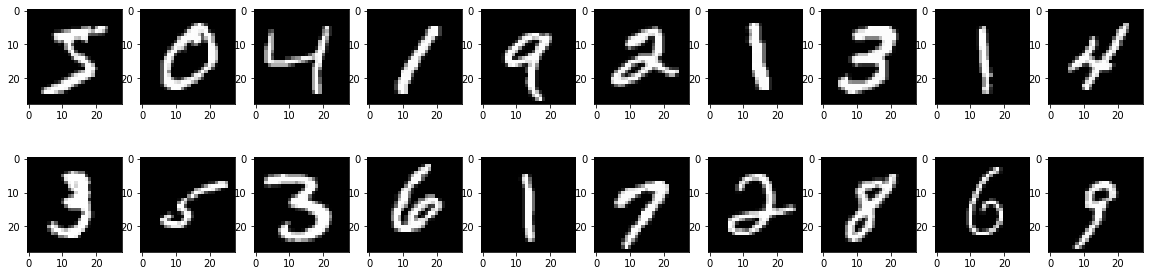

In [5]:
plt.figure(figsize = (20,5))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(all_digits[i], cmap=plt.cm.gray)
plt.show()

In [6]:
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

dataset = tf.data.Dataset.from_tensor_slices(all_digits)

batch_size = 64

dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [7]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
            
        batch_size = tf.shape(real_images)[0]
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            
        generated_images = self.generator(random_latent_vectors)
            
        combined_images = tf.concat([generated_images, real_images], axis=0)    
            
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [8]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [9]:
epochs = 30
gan.fit(dataset,  # в качестве обучающих данных передаём наш объект датасета, созданный ранее, он уже будет работать батчами
        epochs=epochs)

Epoch 1/30
 894/1094 [=======================>......] - ETA: 3:40 - d_loss: 0.5348 - g_loss: 1.1362

KeyboardInterrupt: 